In [1]:
import os
import sys

sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join

import energyflow as ef
import h5py
import hydra
import numpy as np
import pytorch_lightning as pl
import torch
from omegaconf import OmegaConf
from sklearn.neighbors import KernelDensity
import pandas as pd

2023-09-11 01:14:20.848825: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 01:14:21.666283: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# plots and metrics
import matplotlib.pyplot as plt

from src.data.components import (
    calculate_all_wasserstein_metrics,
    inverse_normalize_tensor,
    normalize_tensor,
)
from src.utils.data_generation import generate_data
from src.utils.plotting import apply_mpl_styles, plot_data, prepare_data_for_plotting

apply_mpl_styles()

In [4]:
from jetnet.evaluation import w1efp, w1m, w1p
from src.utils.jet_substructure import dump_hlvs
from src.data.components.metrics import wasserstein_distance_batched
from src.utils.plotting import (
    plot_substructure,
    plot_full_substructure,
)

In [5]:
# set env variable DATA_DIR again because of hydra
from dotenv import load_dotenv

load_dotenv()
os.environ["DATA_DIR"] = os.environ.get("DATA_DIR")

In [6]:
data_folder = os.environ.get("DATA_DIR")

In [10]:
test = np.array([False, True, False, True])
print(test.astype(int))

[0 1 0 1]


# load data

In [7]:
path_preds = "/beegfs/desy/user/ewencedr/data/lhco/preds.h5"
with h5py.File(path_preds, "r") as f:
    pred = f["preds"][:]
    semi_labels = f["semi_labels"][:]
    sample_mjj = f["mjj"][:]
    sample_j = f["sample_j"][:]
    sample_p = f["sample_p"][:]

In [8]:
print(sample_p.shape)

(222351, 2, 279, 3)


In [9]:
#revert pre-processing
def LoadJson(file_name):
    import json,yaml
    JSONPATH = os.path.join(file_name)
    return yaml.safe_load(open(JSONPATH))
data_dict = LoadJson('/home/ewencedr/LHCO_diffusion/scripts/preprocessing_279.json')
batch_size = sample_p.shape[0]
num_part = sample_p.shape[2]
sample_p=sample_p.reshape(-1,sample_p.shape[-1])
mask = np.expand_dims(sample_p[:,0]!=0,-1)
sample_p = sample_p*data_dict['std_particle'] + data_dict['mean_particle']

sample_p[:,0] = 1.0 - np.exp(sample_p[:,0])
sample_p[:,0] = np.clip(sample_p[:,0],2.5349376295699686e-05,1.0) #apply min pt cut
sample_p = (sample_p*mask).reshape(batch_size,2,num_part,-1)
print(sample_p.shape)



(222351, 2, 279, 3)


In [10]:
# revert jet data preprocessing
sample_j = sample_j.reshape(-1,sample_j.shape[-1])
mjj_tile = np.expand_dims(sample_mjj,1)
mjj_tile = np.reshape(np.tile(mjj_tile,(1,2)),(-1))
sample_j = sample_j*data_dict['std_jet'] + data_dict['mean_jet']
sample_j[:,0] = np.exp(sample_j[:,0])*mjj_tile
sample_j[:,4] = np.round(sample_j[:,4])
sample_j[:,4] = np.clip(sample_j[:,4],1,279)
#1 particle jets have 0 mass
mask_mass = sample_j[:,4]>1.0
sample_j[:,3] = np.exp(sample_j[:,3])*mask_mass*mjj_tile
sample_j = sample_j.reshape(batch_size,2,-1)
print(sample_j.shape)

(222351, 2, 5)


In [11]:
pred_bool = pred > 0.5
pred_bool = pred_bool.squeeze()

In [12]:
correct = pred_bool == semi_labels
accuracy = np.sum(correct) / len(correct)
print(f"ACC: {accuracy}")

ACC: 0.8391687017373433


In [13]:
print(np.sum(correct))
print(np.sum(~correct))

186590
35761


In [14]:
correct_j = sample_j[correct]
false_j = sample_j[~correct]
correct_mjj = sample_mjj[correct]
false_mjj = sample_mjj[~correct]
correct_p = sample_p[correct]
false_p = sample_p[~correct]

In [15]:
print(correct_j.shape)
print(correct_p.shape)
print(false_j.shape)
print(false_p.shape)

(186590, 2, 5)
(186590, 2, 279, 3)
(35761, 2, 5)
(35761, 2, 279, 3)


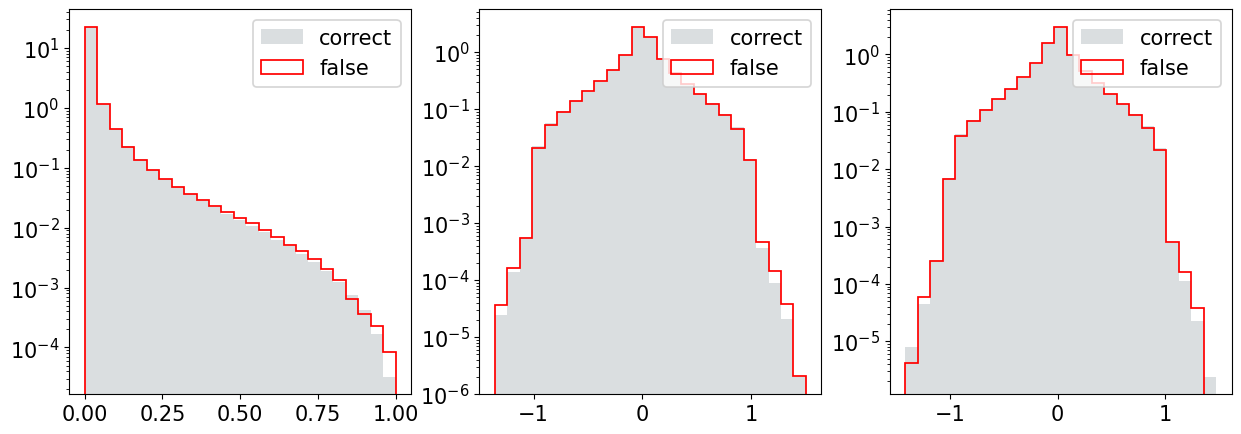

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    #min_bin, max_bin = min(np.min(false_p[..., i]), np.min(correct_p[...,i])), max(np.max(false_p[..., i]), np.max(correct_p[...,i]))
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    bins=25
    hist = ax.hist(correct_p[..., i].flatten()[correct_p[..., i].flatten() != 0], bins=bins, label="correct", alpha=0.5, density=True)
    hist2 = ax.hist(false_p[..., i].flatten()[false_p[..., i].flatten() != 0], bins=hist[1], label="false", histtype="step", color="red", density=True)
    ax.legend()
    ax.set_yscale("log")
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.show()

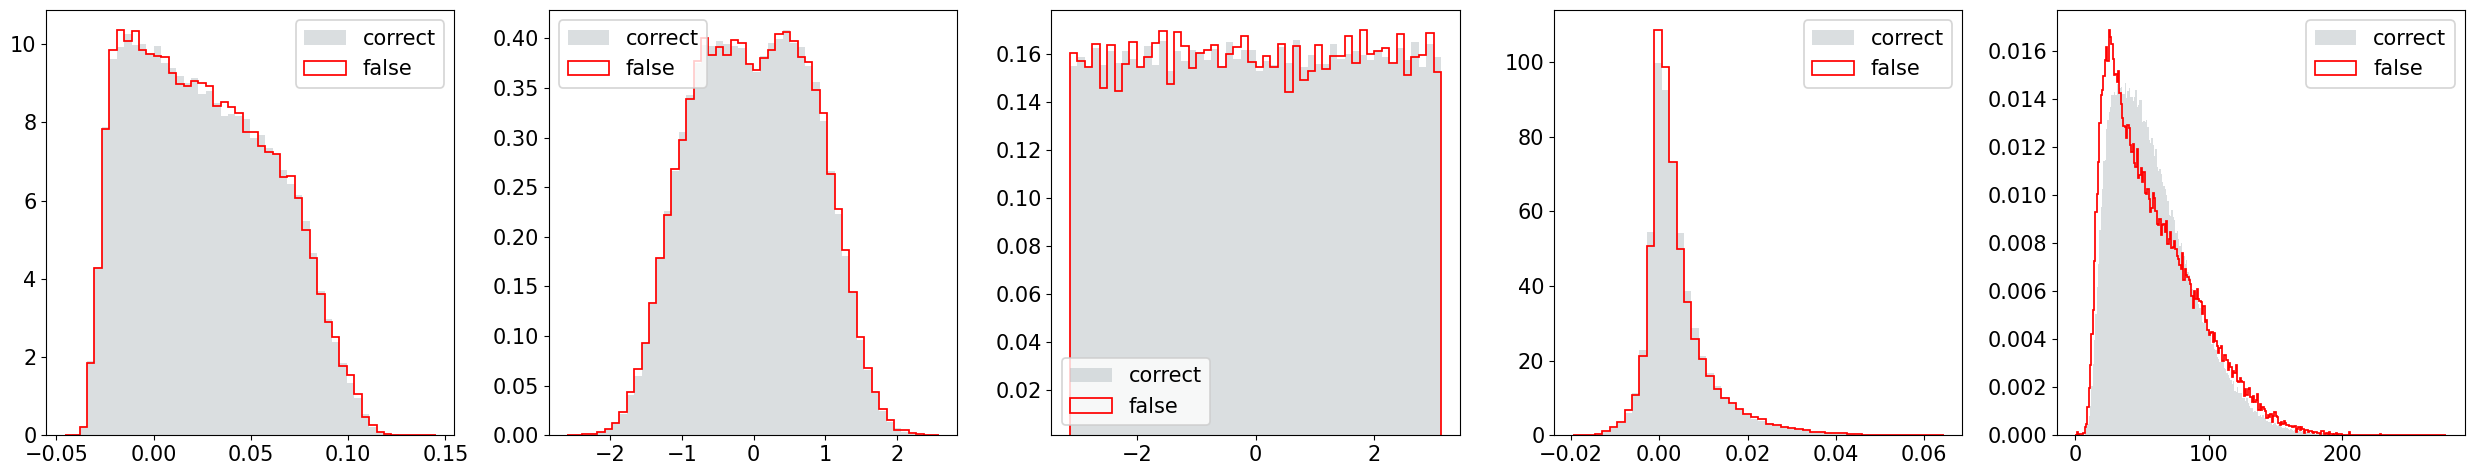

In [30]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
for i, ax in enumerate(axs):
    #min_bin, max_bin = min(np.min(false_j[..., i]), np.min(correct_j[...,i])), max(np.max(false_j[..., i]), np.max(correct_j[...,i]))
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    if i == 4:
        bins =range(0,279)
    else:
        bins = 50
    hist = ax.hist(correct_j[..., i].flatten()[correct_j[..., i].flatten() != 0], bins=bins, label="correct", alpha=0.5, density=True)
    hist2 = ax.hist(false_j[..., i].flatten()[false_j[..., i].flatten() != 0], bins=hist[1], label="false", histtype="step", color="red", density=True)
    ax.legend()
    if i == 2:
        ax.set_ylim(0.001,)
    #ax.set_yscale("log")
    #ax.step(bins[:-1], hist / np.sum(hist), where="post", label="correct")
plt.tight_layout()
plt.show()

In [18]:
print(correct_p.shape)

(186590, 2, 279, 3)


In [21]:
#c_p = correct_p[:len(false_p)]
c_p = correct_p
correct_p_flat = c_p.reshape(c_p.shape[0]*c_p.shape[1], -1)
false_p_flat = false_p.reshape(false_p.shape[0]*false_p.shape[1], -1)

In [22]:
print(correct_p_flat.shape)
print(false_p_flat.shape)

(373180, 837)
(71522, 837)


In [24]:
fig, axs = plt.subplots(93, 9, figsize=(45, 465))
for i, ax in enumerate(axs.flatten()):
    #min_bin, max_bin = min(np.min(false_p_flat[..., i]), np.min(correct_p_flat[...,i])), max(np.max(false_p_flat[..., i]), np.max(correct_p_flat[...,i]))
    #bins = np.linspace(int(min_bin), int(max_bin), 100)
    bins=25
    hist = ax.hist(correct_p_flat[...,i].flatten()[correct_p_flat[..., i].flatten() != 0], bins=bins, alpha=0.5, label="nofool", histtype="stepfilled", density=True)
    ax.hist(false_p_flat[...,i].flatten()[false_p_flat[..., i].flatten() != 0], bins=hist[1], label="fool", histtype="step", density=True)
    #ax.hist(flat_data_v[...,i].flatten()[flat_data_v[..., i].flatten() != 0], bins=hist[1], label="Vini", histtype="step")
    label=""
    if (i+1) % 3 == 1:
        label += " pt"
        #ax.set_yscale("log")
        #print(min_bin, max_bin)
    if (i+1) % 3 == 2:
        label += " eta"
        #ax.set_yscale("log")
    if (i+1) % 3 == 0:
        label += " phi"
        #ax.set_yscale("log")
    #if i < flat_data_id.shape[-1]//2:
    #    label += " first jet"
    #else:
    #    label += " second jet"
    ax.set_yscale("log")
    label += f"{(i//3)}"
    #for j in range(particle_data_id.shape[-2]):
    #    if (i+1) % ((j+1)*3) < 0:
    #        label += f" particle {i}"
    ax.set_xlabel(label)
    ax.legend()
plt.tight_layout()
plt.show()

/home/ewencedr/.conda/envs/pllhome/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
/tmp/ipykernel_2775/2208859565.py:24: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


# tests

In [27]:
path_gen = f"/beegfs/desy/user/ewencedr/data//lhco/generated/idealized_LHCO.h5"
with h5py.File(path_gen, "r") as f:
    jet_data_gen = f["jet_features"][:]
    particle_data_gen = f["particle_features"][:]

jet_data_gen = jet_data_gen[..., :4]
#particle_data_gen = particle_data_gen[..., [1, 2, 0]]

In [37]:
mask_gen = np.expand_dims(np.array(particle_data_gen[..., 0] != 0), axis=-1).astype(
    int
)

In [38]:
print(mask_gen)

[[[[1]
   [1]
   [1]
   ...
   [0]
   [0]
   [0]]

  [[1]
   [1]
   [1]
   ...
   [0]
   [0]
   [0]]]


 [[[1]
   [1]
   [1]
   ...
   [0]
   [0]
   [0]]

  [[1]
   [1]
   [1]
   ...
   [0]
   [0]
   [0]]]


 [[[1]
   [1]
   [1]
   ...
   [0]
   [0]
   [0]]

  [[1]
   [1]
   [1]
   ...
   [0]
   [0]
   [0]]]


 ...


 [[[1]
   [1]
   [1]
   ...
   [0]
   [0]
   [0]]

  [[1]
   [1]
   [1]
   ...
   [0]
   [0]
   [0]]]


 [[[1]
   [1]
   [1]
   ...
   [0]
   [0]
   [0]]

  [[1]
   [1]
   [1]
   ...
   [0]
   [0]
   [0]]]


 [[[1]
   [1]
   [1]
   ...
   [0]
   [0]
   [0]]

  [[1]
   [1]
   [1]
   ...
   [0]
   [0]
   [0]]]]


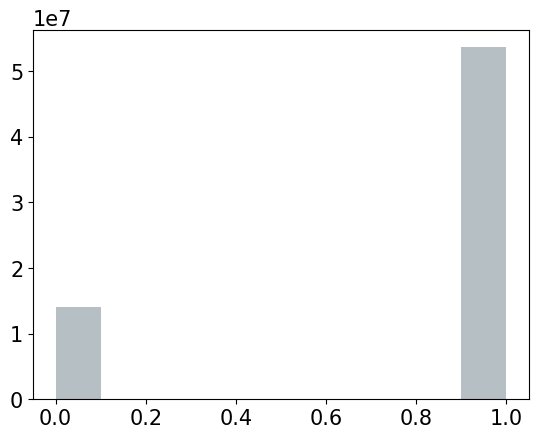

In [32]:
plt.hist(mask_gen.flatten())
plt.show()

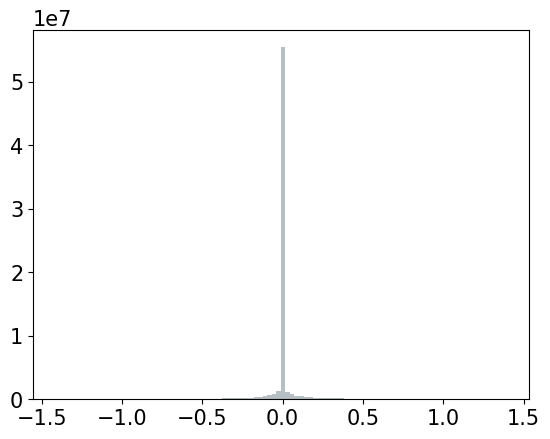

In [28]:
plt.hist(particle_data_gen[..., 2].flatten(), bins=100)
plt.show()

In [14]:
path_bckg = f"/beegfs/desy/user/ewencedr/data/lhco/final_data/processed_data_background_rel.h5"

with h5py.File(path_bckg, "r") as f:
    jet_data_bckg = f["jet_data"][:]
    particle_data_bckg = f["constituents"][:]
    mask_bckg = f["mask"][:]

In [15]:
# cut mjj window
p4_jets_bckg = ef.p4s_from_ptyphims(jet_data_bckg)
# get mjj from p4_jets
sum_p4_bckg = p4_jets_bckg[:, 0] + p4_jets_bckg[:, 1]
mjj_bckg = ef.ms_from_p4s(sum_p4_bckg)

In [16]:
args_to_keep_bckg = (mjj_bckg > 3300) & (mjj_bckg < 3700)

In [17]:
jet_data_bckg = jet_data_bckg[args_to_keep_bckg]
particle_data_bckg = particle_data_bckg[args_to_keep_bckg]
mask_bckg = mask_bckg[args_to_keep_bckg]

In [23]:
print(len(jet_data_bckg))
print(len(particle_data_gen))

121351
121351


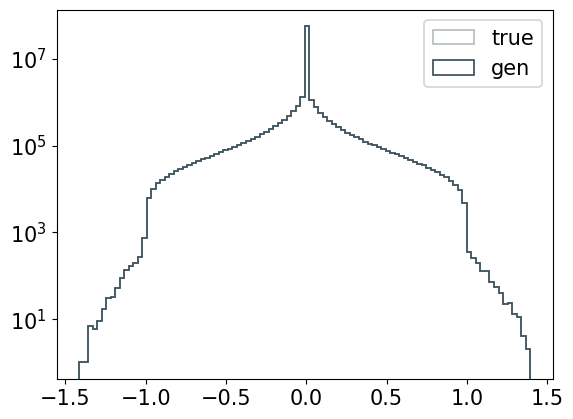

In [30]:
hist = plt.hist(particle_data_bckg[..., 2].flatten(), bins=100, histtype="step", label="true")
plt.hist(particle_data_gen[..., 2].flatten(), bins=100, histtype="step", label="gen")
plt.yscale("log")
plt.legend()
plt.show()